# Week 3: [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) 
### Description
MicroscopeIn this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

`[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.`

### Deliverable 1 
A Jupyter notebook with a description of the problem/data, exploratory data analysis (EDA) procedure, analysis (model building and training), result, and discussion/conclusion.

### 1. Problem Description & Exploratory Data Analysis (EDA)

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import time

2025-11-18 10:12:37.635017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data
##### I won't be commiting these folders due to its large size! #####
TRAIN_PATH = "train"
TEST_PATH = "test"

In [3]:
# Load labels
train_labels = pd.read_csv("train_labels.csv")

print(f"train_labels.csv")
print(f"Training samples: {len(train_labels)}")
print(train_labels.head())

train_labels.csv
Training samples: 220025
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [4]:
# Check for duplicates/invalids
print(f"Null values: {train_labels.isnull().sum().sum()}")
print(f"Duplicates: {train_labels['id'].duplicated().sum()}")

# Class distribution
class_counts = train_labels['label'].value_counts()
class_pct = train_labels['label'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
print(f"  No Tumor (0): {class_counts[0]:,} ({class_pct[0]:.2f}%)")
print(f"  Tumor (1):    {class_counts[1]:,} ({class_pct[1]:.2f}%)")
print(f"  Class Balance Ratio: {class_counts[1]/class_counts[0]:.3f}")

Null values: 0
Duplicates: 0

Class Distribution:
  No Tumor (0): 130,908 (59.50%)
  Tumor (1):    89,117 (40.50%)
  Class Balance Ratio: 0.681


Null values: 0
Duplicates: 0
Class Distribution:
  No Tumor (0): 130,908 (59.50%)
  Tumor (1):    89,117 (40.50%)
  Class Balance Ratio: 0.681


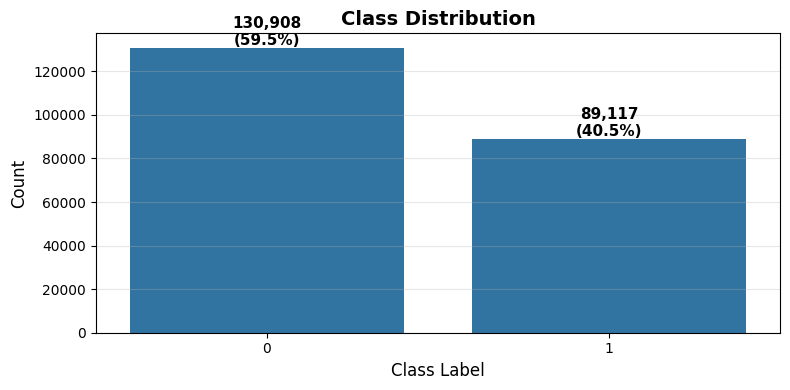

In [5]:
# Check for duplicates/invalids
print(f"Null values: {train_labels.isnull().sum().sum()}")
print(f"Duplicates: {train_labels['id'].duplicated().sum()}")

# Class distribution
class_counts = train_labels['label'].value_counts()
class_pct = train_labels['label'].value_counts(normalize=True) * 100

print(f"Class Distribution:")
print(f"  No Tumor (0): {class_counts[0]:,} ({class_pct[0]:.2f}%)")
print(f"  Tumor (1):    {class_counts[1]:,} ({class_pct[1]:.2f}%)")
print(f"  Class Balance Ratio: {class_counts[1]/class_counts[0]:.3f}")

# Bar plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, ax=ax)
ax.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Class Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.3)

for i, (count, pct) in enumerate(zip(class_counts.values, class_pct.values)):
    ax.text(i, count + 1000, f'{count:,}\n({pct:.1f}%)', 
            ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [6]:
# Verify files
train_ids = train_labels['id']
missing_files = []
for img_id in train_ids:
    img_path = os.path.join(TRAIN_PATH, f"{img_id}.tif")
    if not os.path.exists(img_path):
        print(f"  Missing file ID: {img_id}")
        missing_files.append(img_id)

print(f"Missing files from {len(train_ids)} images: {len(missing_files)}")

Missing files from 220025 images: 0


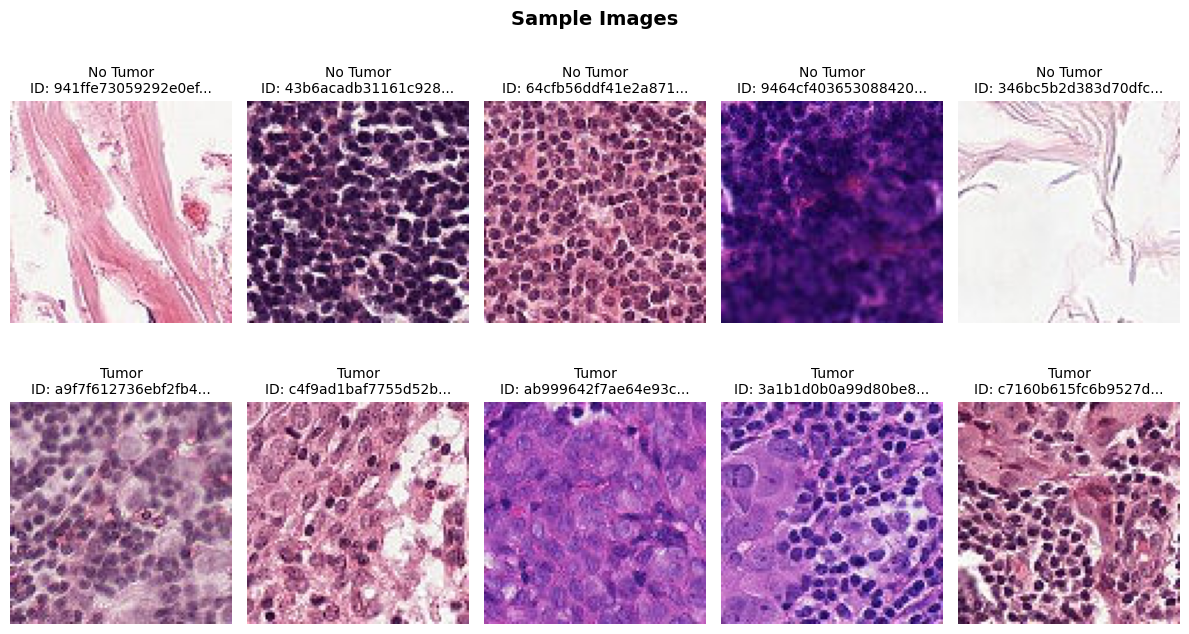

In [7]:
# Sample Image Loading and Analysis
def load_sample_images(df, label, n_samples=5, train_path=TRAIN_PATH):
    """Load random sample images for a given label"""
    sample_ids = df[df['label'] == label].sample(n_samples, random_state=42)['id'].values
    images = []
    ids = []
    
    for img_id in sample_ids:
        img_path = os.path.join(train_path, f"{img_id}.tif")
        try:
            img = Image.open(img_path)
            images.append(np.array(img))
            ids.append(img_id)
        except Exception as e:
            print(f"Error loading {img_id}: {e}")
    
    return images, ids

no_tumor_imgs, no_tumor_ids = load_sample_images(train_labels, label=0, n_samples=5)
tumor_imgs, tumor_ids = load_sample_images(train_labels, label=1, n_samples=5)
    
# Visualize Sample Images
fig, axes = plt.subplots(2, 5, figsize=(12, 7))

# No tumor samples
for idx, (img, img_id) in enumerate(zip(no_tumor_imgs, no_tumor_ids)):
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f'No Tumor\nID: {img_id[:18]}...', fontsize=10)
    axes[0, idx].axis('off')

# Tumor samples
for idx, (img, img_id) in enumerate(zip(tumor_imgs, tumor_ids)):
    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f'Tumor\nID: {img_id[:18]}...', fontsize=10)
    axes[1, idx].axis('off')

plt.suptitle('Sample Images', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


No Tumor - Color Statistics:
  Red   - Mean: 160.93, Std: 79.06
  Green - Mean: 123.47, Std: 89.50
  Blue  - Mean: 158.82, Std: 65.59

Tumor - Color Statistics:
  Red   - Mean: 166.24, Std: 49.21
  Green - Mean: 110.33, Std: 53.68
  Blue  - Mean: 163.42, Std: 44.50


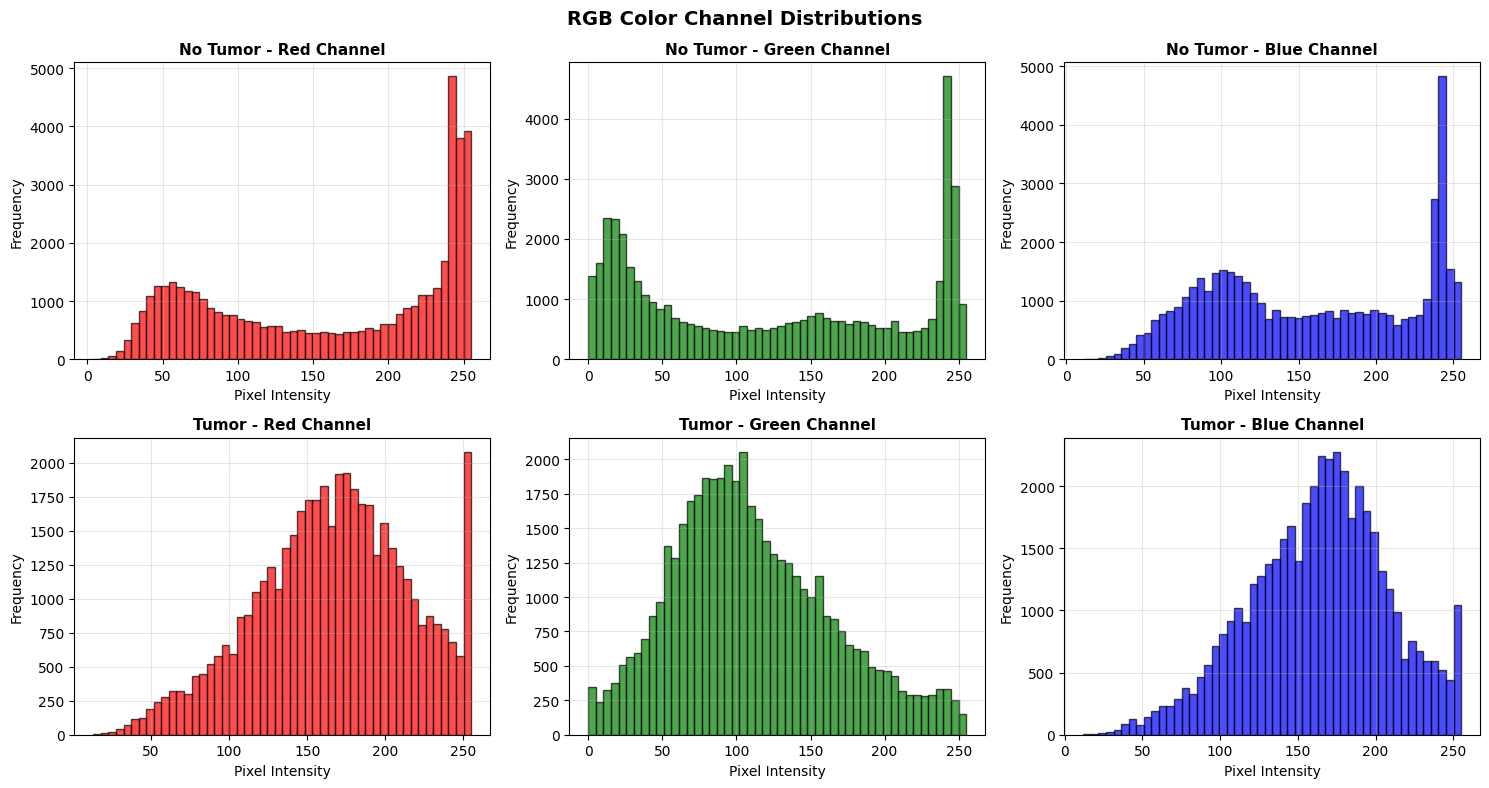

In [8]:
# Color Distribution Analysis
def analyze_color_distribution(images, label_name):
    """Analyze RGB color distribution across images"""
    all_pixels = np.concatenate([img.reshape(-1, 3) for img in images])
    
    print(f"\n{label_name} - Color Statistics:")
    print(f"  Red   - Mean: {all_pixels[:, 0].mean():.2f}, Std: {all_pixels[:, 0].std():.2f}")
    print(f"  Green - Mean: {all_pixels[:, 1].mean():.2f}, Std: {all_pixels[:, 1].std():.2f}")
    print(f"  Blue  - Mean: {all_pixels[:, 2].mean():.2f}, Std: {all_pixels[:, 2].std():.2f}")
    return all_pixels

no_tumor_pixels = analyze_color_distribution(no_tumor_imgs, "No Tumor")
tumor_pixels = analyze_color_distribution(tumor_imgs, "Tumor")

# Visualize Color Distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

colors = ['red', 'green', 'blue']
channel_names = ['Red', 'Green', 'Blue']

for i, (color, name) in enumerate(zip(colors, channel_names)):
    # No tumor
    axes[0, i].hist(no_tumor_pixels[:, i], bins=50, color=color, alpha=0.7, edgecolor='black')
    axes[0, i].set_title(f'No Tumor - {name} Channel', fontsize=11, fontweight='bold')
    axes[0, i].set_xlabel('Pixel Intensity')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].grid(True, alpha=0.3)
    
    # Tumor
    axes[1, i].hist(tumor_pixels[:, i], bins=50, color=color, alpha=0.7, edgecolor='black')
    axes[1, i].set_title(f'Tumor - {name} Channel', fontsize=11, fontweight='bold')
    axes[1, i].set_xlabel('Pixel Intensity')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].grid(True, alpha=0.3)

plt.suptitle('RGB Color Channel Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
# Image Brightness and Contrast Analysis
def compute_image_stats(images):
    """Compute brightness and contrast statistics"""
    brightness = [img.mean() for img in images]
    contrast = [img.std() for img in images]
    return brightness, contrast

no_tumor_bright, no_tumor_contrast = compute_image_stats(no_tumor_imgs)
tumor_bright, tumor_contrast = compute_image_stats(tumor_imgs)

print(f"No Tumor - Brightness: {np.mean(no_tumor_bright):.2f} ± {np.std(no_tumor_bright):.2f}")
print(f"No Tumor - Contrast:   {np.mean(no_tumor_contrast):.2f} ± {np.std(no_tumor_contrast):.2f}")
print(f"Tumor    - Brightness: {np.mean(tumor_bright):.2f} ± {np.std(tumor_bright):.2f}")
print(f"Tumor    - Contrast:   {np.mean(tumor_contrast):.2f} ± {np.std(tumor_contrast):.2f}")

No Tumor - Brightness: 147.74 ± 64.90
No Tumor - Contrast:   45.05 ± 15.55
Tumor    - Brightness: 146.67 ± 10.99
Tumor    - Contrast:   54.09 ± 6.55


### 2. Analysis (Model Building & Training)

In [10]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPUS Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.16.2
GPUS Available: []


In [11]:
# Data Preparation - Train/Validation Split
# 80/20 split
train_df, valid_df = train_test_split(
    train_labels, 
    test_size=0.2, 
    stratify=train_labels['label'],
    random_state=42
)

print(f"Training set size: {len(train_df):,} samples")
print(f"Validation set size: {len(valid_df):,} samples")

Training set size: 176,020 samples
Validation set size: 44,005 samples


In [12]:
# Class distribution in splits
train_dist = train_df['label'].value_counts(normalize=True) * 100
valid_dist = valid_df['label'].value_counts(normalize=True) * 100

print(f"Training distribution:")
print(f"  No Tumor: {train_dist[0]:.2f}%")
print(f"  Tumor:    {train_dist[1]:.2f}%\n")

print(f"Validation distribution:")
print(f"  No Tumor: {valid_dist[0]:.2f}%")
print(f"  Tumor:    {valid_dist[1]:.2f}%")

# Save splits
# train_df.to_csv('train_split.csv', index=False)
# valid_df.to_csv('valid_split.csv', index=False)

Training distribution:
  No Tumor: 59.50%
  Tumor:    40.50%

Validation distribution:
  No Tumor: 59.50%
  Tumor:    40.50%


In [13]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='reflect'
)

# Rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Create Data Generators
BATCH_SIZE = 32 # Default batch size. GPU with more memory: increase to 64 or 128
IMG_SIZE = (96, 96)

# Make copies
train_df_gen = train_df.copy()
valid_df_gen = valid_df.copy()

# Add .tif extension
# e.g. 0a0a1f3867f41e02353afcaf503f63be1bdd35ec.tif
train_df_gen['filename'] = train_df_gen['id'] + '.tif'
valid_df_gen['filename'] = valid_df_gen['id'] + '.tif'

# Labels must be strings
train_df_gen['label'] = train_df_gen['label'].astype(str)
valid_df_gen['label'] = valid_df_gen['label'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_gen,
    directory=TRAIN_PATH,
    x_col='filename',  # Switch from 'id' to 'filename'
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df_gen,
    directory=TRAIN_PATH,
    x_col='filename',  # Switch from 'id' to 'filename'
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

print(f"Training batches: {len(train_generator)} and samples: {train_generator.samples}")
print(f"Validation batches: {len(valid_generator)} and samples: {valid_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Training batches: 5501 and samples: 176020
Validation batches: 1376 and samples: 44005
Class indices: {'0': 0, '1': 1}


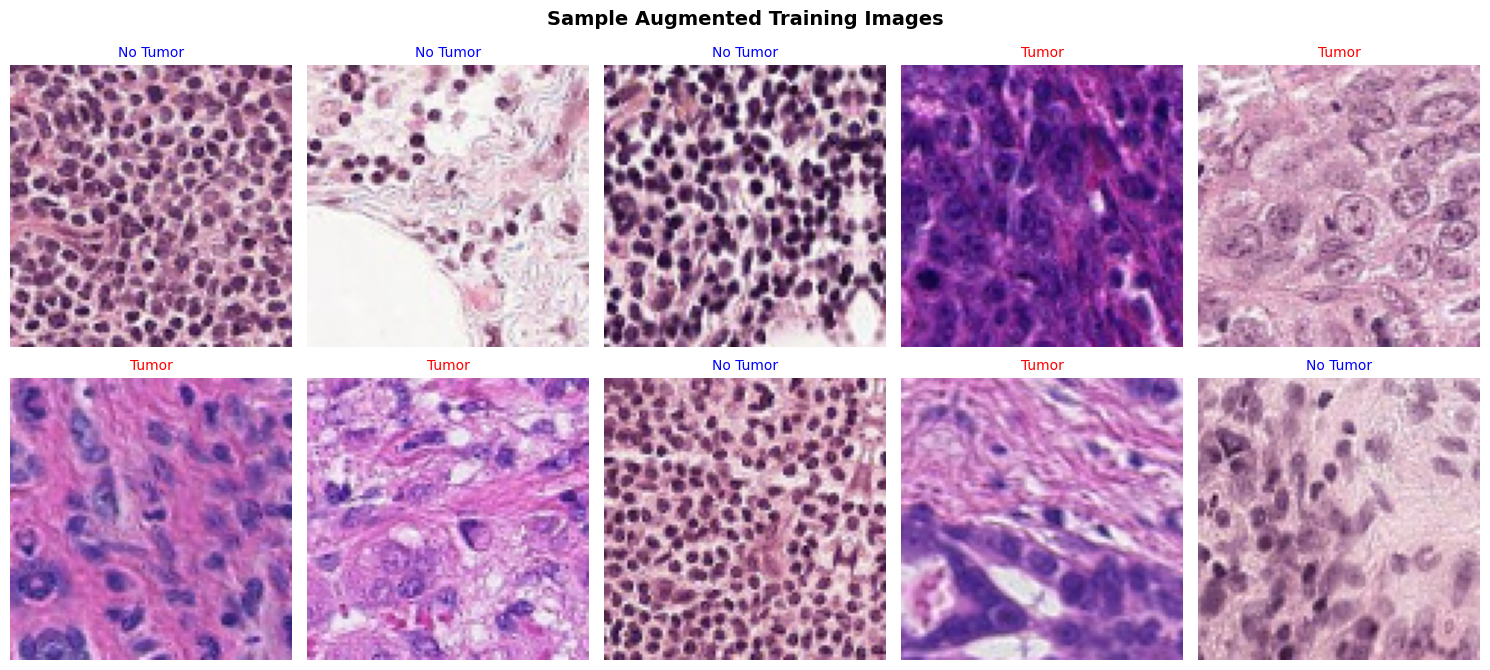

In [15]:
# Visualizing Augmented Images
# Get a sample batch
sample_batch = next(train_generator)
sample_images = sample_batch[0][:10]
sample_labels = sample_batch[1][:10]

fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.ravel()

for idx, (img, label) in enumerate(zip(sample_images, sample_labels)):
    axes[idx].imshow(img)
    axes[idx].set_title(f'{"Tumor" if label == 1 else "No Tumor"}', 
                       fontsize=10, 
                       color='red' if label == 1 else 'blue')
    axes[idx].axis('off')

plt.suptitle('Sample Augmented Training Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
# Model Architecture
# Custom CNN

def create_cnn_model(input_shape=(96, 96, 3)):
    """
    Create a CNN model for binary classification
    """
    model = models.Sequential([
        # Input Layer
        layers.Input(shape=input_shape),
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv6'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool3'),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu', name='dense1'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', name='dense2'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    return model

# Create CNN model
model = create_cnn_model()

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,042,209 (19.23 MB)

 Trainable params: 5,040,545 (19.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

None


In [17]:
# Model Compilation
# Compile model
OPTIMIZER_ADAM = 0.001
LOSS = 'binary_crossentropy'

model.compile(
    optimizer=Adam(learning_rate=OPTIMIZER_ADAM),
    loss=LOSS,
    metrics=['accuracy', 
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [18]:
# Callbacks Configuration
ES_PATIENCE = 10
RLRP_PATIENCE = 5
MONITOR = 'val_auc'
RLRP_MONITOR = 'val_loss'

early_stopping = EarlyStopping(
    monitor=MONITOR,
    patience=ES_PATIENCE,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor=MONITOR,
    mode='max',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor=RLRP_MONITOR,
    factor=0.5,
    patience=RLRP_PATIENCE,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [19]:
# Model Training
EPOCHS = 5 # or ~50! Adjust as needed! 
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"Training completed in {training_time/60:.2f} minutes for {EPOCHS} epochs!")

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.8124 - auc: 0.8782 - loss: 0.4361 - precision: 0.7794 - recall: 0.7479
Epoch 1: val_auc improved from None to 0.71787, saving model to best_model.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 5178s 940ms/step - accuracy: 0.8413 - auc: 0.9102 - loss: 0.3719 - precision: 0.8160 - recall: 0.7852 - val_accuracy: 0.6341 - val_auc: 0.7179 - val_loss: 1.0865 - val_precision: 0.6334 - val_recall: 0.2294 - learning_rate: 0.0010
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8806 - auc: 0.9447 - loss: 0.2908 - precision: 0.8673 - recall: 0.8348
Epoch 2: val_auc did not improve from 0.71787
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 6310s 1s/step - accuracy: 0.8886 - auc: 0.9501 - loss: 0.2752 - precision: 0.8774 - recall: 0.8429 - val_accuracy: 0.7129 - val_auc: 0.6484 - val_loss: 2.5003 - val_precision: 0.9804 - val_recall: 0.2971 - learning_rate: 0.0010
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.9038 -

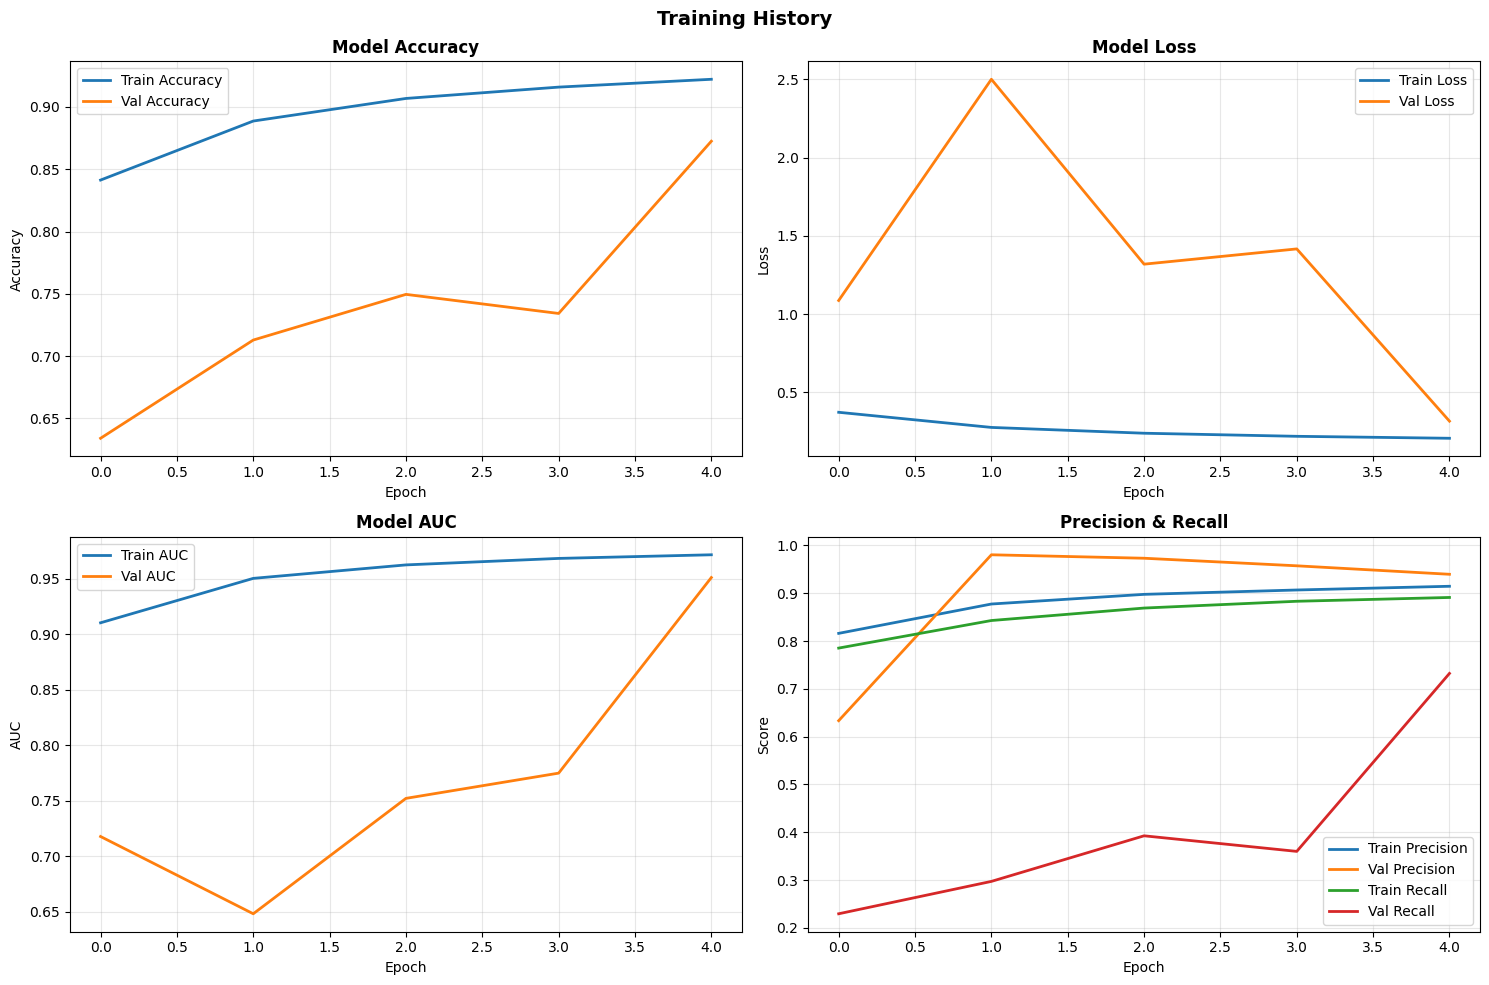

In [20]:
# Training History Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUC
axes[1, 0].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[1, 0].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[1, 0].set_title('Model AUC', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 1].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Precision & Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [23]:
# Final Model Evaluation
# This reloads the best saved model from disk
model = keras.models.load_model('best_model.keras')

# Evaluate on validation set
val_results = model.evaluate(valid_generator, verbose=0)

print(f"Loss: {val_results[0]:.4f}")
print(f"Accuracy: {val_results[1]:.4f}")
print(f"AUC: {val_results[2]:.4f}")
print(f"Precision: {val_results[3]:.4f}")
print(f"Recall: {val_results[4]:.4f}")

# Calculate F1 Score
f1_score = 2 * (val_results[3] * val_results[4]) / (val_results[3] + val_results[4])
print(f"F1 Score: {f1_score:.4f}")

Loss: 0.3152
Accuracy: 0.8725
AUC: 0.9509
Precision: 0.9396
Recall: 0.7322
F1 Score: 0.8230


In [25]:
# Generate Predictions for Test Set
# Load test data
test_files = os.listdir(TEST_PATH)
test_ids = [f.replace('.tif', '') for f in test_files if f.endswith('.tif')]

# Create test dataframe with filename column
test_df = pd.DataFrame({'id': test_ids})
test_df['filename'] = test_df['id'] + '.tif'  # Add .tif extension

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_PATH,
    x_col='filename',  # Changed from 'id' to 'filename'
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

print(f"Test batches: {len(test_generator)}")
print(f"Test samples found: {test_generator.samples}")

# Generate predictions
predictions = model.predict(test_generator, verbose=1)

# Submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': predictions.flatten()
})

submission.to_csv('submission.csv', index=False)
print(submission.head(10))

Found 57458 validated image filenames.
Test batches: 1796
Test samples found: 57458
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 287s 160ms/step
                                         id     label
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d  0.146406
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581  0.311404
2  19709bec800f372d0b1d085da6933dd3ef108846  0.370986
3  7a34fc34523063f13f0617f7518a0330f6187bd3  0.212337
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed  0.035292
5  761dde7de22cb39a0dd67ce472163d66e5ac1568  0.098462
6  58055ce8819717a100b48d019e139be4fdf997c0  0.278965
7  9735b584631f4b942b022d40aecdbe2aa8f6ae5e  0.002624
8  860bbd33f8483a45858c4998021bc7434117deda  0.086074
9  99050fbce64ae16e48e8a3b09d38f3b16df63fbe  0.630429


### 3. Results
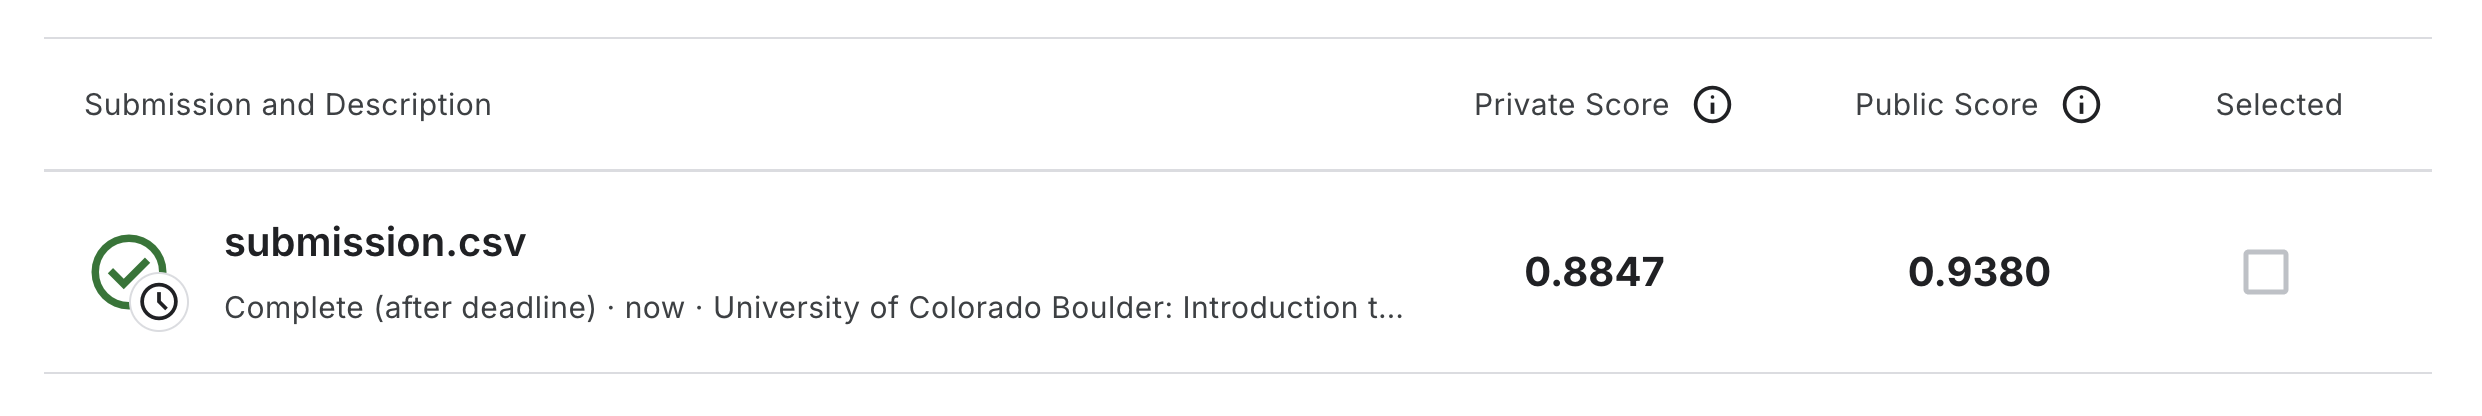